In [301]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pandas.plotting as pd_plot
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import sklearn.model_selection as ModelSelection
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

PriceCategory distribution difference
PriceCategory
10.0    0.000856
15.0   -0.000856
20.0    0.000000
5.0    -0.001712
30.0    0.000000
25.0    0.001712
0.0     0.000000
Name: count, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 510 to 308
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1168 non-null   int64   
 1   LotFrontage    955 non-null    float64 
 2   LotArea        1168 non-null   int64   
 3   OverallQual    1168 non-null   int64   
 4   OverallCond    1168 non-null   int64   
 5   YearRemodAdd   1168 non-null   int64   
 6   MasVnrArea     1161 non-null   float64 
 7   BsmtFinSF1     1168 non-null   int64   
 8   BsmtFinSF2     1168 non-null   int64   
 9   BsmtUnfSF      1168 non-null   int64   
 10  TotalBsmtSF    1168 non-null   int64   
 11  1stFlrSF       1168 non-null   int64   
 12  2ndFlrSF       1168 non-null   int64   
 13  LowQualFinSF   116

ValueError: Input contains NaN

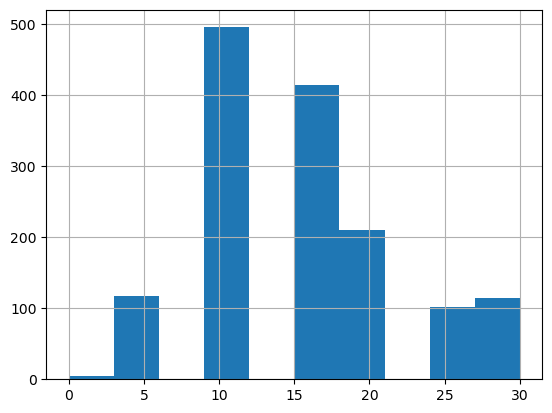

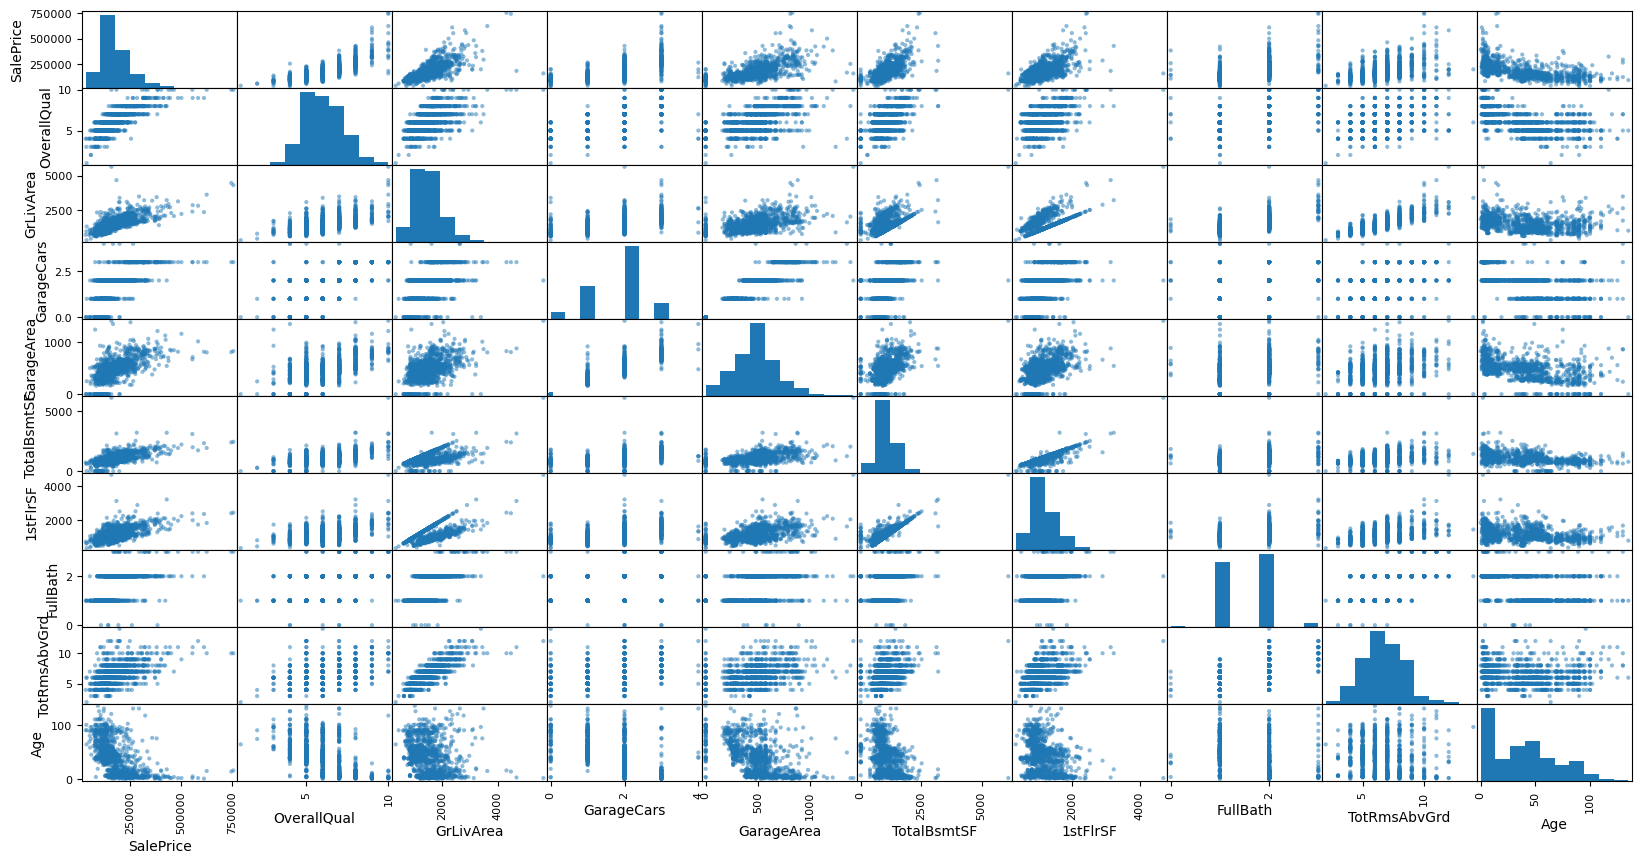

In [308]:
# importing local modules is pain, so base code located here.

class GenericDataset:
    def __init__(self, df):
        self._df = df

    def split_numeric(self):
        numeric_df = self._df.select_dtypes(include=['number'])
        non_numeric_df = self._df.select_dtypes(exclude=['number'])
        return numeric_df, non_numeric_df

    def impute_nums(self):
        num, non_num = self.split_numeric()
        imputer = SimpleImputer(strategy="median")
        imputer.fit(num)
        X = imputer.transform(num)
        num_imputed = pd.DataFrame(X, columns=num.columns)
        return pd.concat([num_imputed, non_num], axis=1)

class Data:
    def __init__(self):
        raw_data = pd.read_csv("./data/train.csv")
        self._final_test = pd.read_csv("./data/test.csv")

        train_set,test_set = self._make_split_by_price(raw_data)
        self._test = self.__prepare(test_set)
        self._train = self.__prepare(train_set)

    # Make stratified sampling by house pricing
    def _make_split_by_price(self, refDf):
        df = refDf.copy()
        df["PriceCategory"] = pd.cut(df["SalePrice"], bins=[0, 50_000,100_000,150_000,200_000,250_000,300_000,np.inf],labels = [0.0, 5.0,10.0,15.0,20.0,25.0,30.0])
        df["PriceCategory"].hist()
        train, test = self._split_by_column(df, "PriceCategory")
        train.drop(columns=["PriceCategory"])
        test.drop(columns=["PriceCategory"])
        return train, test

    def _split_by_column(self, df, column_name):
        split = ModelSelection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        train_idx, test_idx = list(split.split(df, df[column_name]))[0]
        strat_train_set = df.loc[train_idx]
        strat_test_set = df.loc[test_idx]

        print("{} distribution difference".format(column_name))
        print(strat_train_set[column_name].value_counts() / len(strat_train_set) - strat_test_set[column_name].value_counts() / len(strat_test_set))
        return strat_train_set, strat_test_set
        
    
    def __prepare(self, rawDf):
        df = rawDf.copy()
        dataset = GenericDataset(df)
        df = dataset.impute_nums()
        df = self.__gen_data(df)
        # TODO: handle NA in nominal data
        return df.drop(columns=["Id"])

    def __derive(self, df):
        imputer = SimpleImputer(strategy="median")
        return imputer.fit(df)

    # TODO: handle NA in numeric data
    def __gen_data(self, df):
        df["Age"] = df["YearBuilt"].max()-df["YearBuilt"]
        return df.drop(columns=["YearBuilt"])

    
    def _info(self):
        print(self._train.info())
        print(self._train.describe())

    def _show(self):
        self._train.hist(bins=50, figsize=(20,15))
        plt.show()
        
    def _correlation(self):
        corr_matrix = self._train.corr(numeric_only=True)
        print("================correlation(abs)================\n\n")
        print(corr_matrix["SalePrice"].abs().sort_values(ascending=False))
        print("================correlation(abs)================\n\n")

    def _get_most_correlated_attrs(self):
        corr_matrix = self._train.corr(numeric_only=True)
        sorted = corr_matrix["SalePrice"].abs().sort_values(ascending=False).head(10)
        return [(index) for index in sorted.index]
    
    def _scatter(self):
        print("================top 10 correlated(abs) features scatter pl================\n\n")
        attrs = self._get_most_correlated_attrs()
        pd_plot.scatter_matrix(self._train[attrs], figsize=(20,10))
        
    
    def describe(self):
        self._info()
        # self._show()
        self._correlation()
        self._scatter()


    def _parse_non_numeric_data(self):
        # TODO: handle non-numeric data
        pass

    def train_frame(self):
        return self._train.drop(columns=["SalePrice"]), self._train["SalePrice"].copy()


class Model:
    # Data should not contain NaN's
    def __init__(self, data):
        self._data = data
        self._lin_reg=LinearRegression()

    def linear_train(self):
        featured_df, label = self._data.train_frame()
        self._lin_reg.fit(featured_df, label)
        return

    def linear_predict(featured_df):
        return self._lin_reg.predict(featured_df)
        
        

data = Data()
data.describe()

model = Model(data)

model.linear_train()

In [ ]:
data.describe()